# Predict basal area from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular import *

Run the example workflow for predicting the basal area of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
preprocessor = EnvecoPreprocessor('../../../andras/ml/AV_leafon/AV.leaf.on.train.csv', 
                                  '../../../andras/ml/AV_leafon/AV.leaf.on.val.csv',
                                  '../../../andras/ml/AV_leafon/AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
preprocessor.train_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,258.78,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121B3.laz,2013-07-11,C,NaN,NaN,NaN,77,0
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,3.50,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D1.laz,2013-07-11,C,NaN,NaN,NaN,2,0
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,18.79,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,8,0
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,76.84,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121D3.laz,2013-07-11,C,NaN,NaN,NaN,24,0
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,0.00,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_17_automaattinen/2013/20130114_BLOM_ahtari_block2_kesa/1/N4121F1.laz,2013-07-11,C,NaN,NaN,NaN,0,0


In [5]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='v', path='../../../andras/ml/AV_leafon/AV_las/', 
                                                     min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True,
                                                     log_y=False)

Adding height based features
Adding point distribution based features
Adding intensity based features
Adding height quantiles
Adding point proportions
Adding canopy densities


Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [6]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

Check the distribution of the target variable `g`, in order to get limits for `sigmoid_range`.

In [7]:
trainval_tb.train.y.describe()

count    1044.000000
mean      145.712250
std        86.097336
min         2.700000
25%        80.927498
50%       132.125000
75%       191.305000
max       867.349976
Name: v, dtype: float64

In [8]:
trainval_tb.valid.y.describe()

count    225.000000
mean     150.768631
std       95.610825
min        2.310000
25%       87.419998
50%      133.600006
75%      191.639999
max      539.479980
Name: v, dtype: float64

In [9]:
test_tb.train.y.describe()

count    225.000000
mean     152.013641
std       97.223846
min        7.000000
25%       87.820000
50%      134.979996
75%      192.529999
max      550.169983
Name: v, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 70 m² as the maximum value for basal area.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [10]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 58'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
BatchNorm1d          64 x 58              116        True      
________________________________________________________________
Linear               64 x 200             11,600     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

Find learning rate to use.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0030199517495930195)

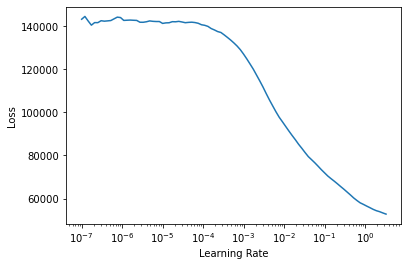

In [11]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,127107.359375,104240.304688,322.862671,214.144485,313.122223,207.683960,313.353088,-10.453969,00:00
1,88152.195312,28756.107422,169.576263,112.474510,137.695602,91.329094,150.816788,-2.159733,00:00
2,53106.210938,4427.929688,66.542694,44.135639,29.016918,19.245995,48.239315,0.513457,00:00
3,33889.082031,2645.024414,51.429802,34.111740,8.689093,5.763197,37.240864,0.709364,00:00
4,22960.531250,2049.612061,45.272640,30.027893,-3.470922,-2.302152,31.905918,0.774788,00:00
5,16130.756836,1907.025269,43.669502,28.964584,-0.828363,-0.549427,30.884558,0.790455,00:00
6,11684.404297,1786.846924,42.271111,28.037075,3.542096,2.349359,29.909016,0.803660,00:00
7,8669.610352,1910.582886,43.710217,28.991589,10.213235,6.774112,30.702143,0.790064,00:00
8,6574.387695,1752.091675,41.857990,27.763065,5.610480,3.721252,29.763205,0.807479,00:00
9,5107.605957,1720.648926,41.480705,27.512825,2.854883,1.893552,29.352566,0.810934,00:00


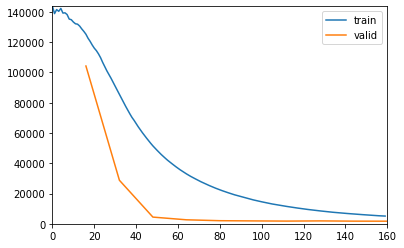

In [12]:
learn.fit_one_cycle(10, max_lr=1e-2, cbs=ShowGraphCallback())

See validation results

In [13]:
learn.validate()

(#7) [1720.64892578125,41.48070526123047,27.51282501220703,2.8548827171325684,1.8935524225234985,29.35256576538086,0.8109343692132399]

`RegressionInterpretation` can be used to plot results.

In [14]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

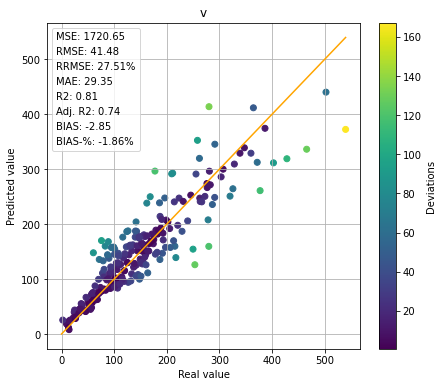

In [15]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [16]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [23]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

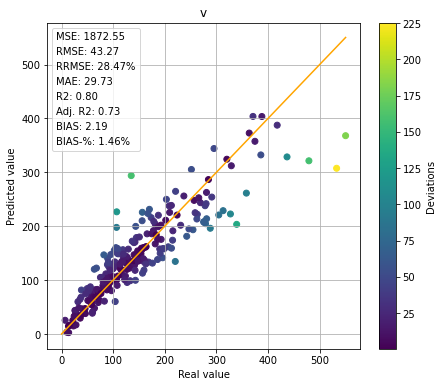

In [24]:
test_interp.plot_results()
plt.show()

# Ensemble of ANNs

Fit several models at once.

In [38]:
ensemble = ANNEnsemble(dls, 
                       y_range=(0,1000), 
                       metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], n_models=10)

In [39]:
ensemble.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,189596.656250,142800.171875,377.889099,250.641754,364.007263,241.434372,364.269501,-14.690944,00:00
1,136722.125000,46406.437500,215.421509,142.882187,184.329361,122.259766,195.486771,-4.099159,00:00
2,83825.468750,9108.976562,95.440956,63.302933,58.204765,38.605358,72.264626,-0.000898,00:00
3,53311.824219,4088.158447,63.938709,42.408501,19.222965,12.749978,44.578953,0.550791,00:00
4,35881.566406,2340.023682,48.373791,32.084785,-0.419636,-0.278331,34.868378,0.742877,00:00
5,25026.998047,2035.345337,45.114799,29.923204,1.760756,1.167853,32.440075,0.776355,00:00
6,17922.705078,2020.693970,44.952129,29.815310,8.660289,5.744092,32.034443,0.777965,00:00
7,13132.346680,1815.072266,42.603668,28.257650,0.456420,0.302729,30.502783,0.800559,00:00
8,9839.955078,1794.564209,42.362297,28.097557,3.558578,2.360291,30.237631,0.802813,00:00
9,7566.894531,1798.594604,42.409843,28.129091,3.622709,2.402827,30.302374,0.802370,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,119539.250000,101851.242188,319.141418,211.676285,309.115448,205.026382,309.616028,-10.191459,00:00
1,81394.125000,25683.164062,160.259674,106.295120,120.652885,80.025200,140.987076,-1.822077,00:00
2,48821.761719,3498.912598,59.151608,39.233368,27.622778,18.321304,44.176567,0.615538,00:00
3,31301.541016,2785.480713,52.777653,35.005726,13.232265,8.776538,36.175476,0.693930,00:00
4,21203.960938,1798.629395,42.410252,28.129364,1.336690,0.886584,29.638416,0.802366,00:00
5,14952.667969,1785.306641,42.252888,28.024990,2.200731,1.459675,29.104362,0.803830,00:00
6,10884.496094,1750.006104,41.833076,27.746540,2.386546,1.582919,29.020388,0.807709,00:00
7,8137.291992,1725.336792,41.537174,27.550280,4.893115,3.245447,28.927834,0.810419,00:00
8,6237.452637,1815.652588,42.610477,28.262165,6.739427,4.470046,29.224588,0.800495,00:00
9,4878.815430,1850.263062,43.014683,28.530264,8.816379,5.847622,29.480820,0.796692,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,143409.203125,122441.484375,349.916412,232.088348,338.285095,224.373672,338.754944,-12.453924,00:00
1,100945.835938,32757.257812,180.989670,120.044662,152.543304,101.177094,163.523773,-2.599382,00:00
2,61063.304688,5775.916992,75.999451,50.408005,42.915993,28.464804,55.683849,0.365340,00:00
3,38934.929688,2509.098145,50.090900,33.223690,5.107839,3.387866,35.969913,0.724299,00:00
4,26337.896484,2100.730713,45.833733,30.400049,2.602284,1.726012,32.749355,0.769171,00:00
5,18488.759766,1910.333374,43.707359,28.989693,3.038597,2.015404,30.812695,0.790092,00:00
6,13343.791992,1812.572632,42.574318,28.238184,3.624662,2.404122,29.465532,0.800834,00:00
7,9845.475586,1904.632935,43.642097,28.946409,7.413829,4.917356,30.349510,0.790718,00:00
8,7416.408203,1994.360962,44.658268,29.620399,9.859937,6.539781,30.862638,0.780859,00:00
9,5734.441895,1908.318848,43.684307,28.974405,7.393917,4.904149,30.309387,0.790313,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,109625.539062,103775.460938,322.141968,213.666458,310.750610,206.110931,312.089905,-10.402892,00:00
1,73294.664062,21995.117188,148.307495,98.367622,105.533051,69.996696,129.921051,-1.416833,00:00
2,43461.878906,4441.714355,66.646187,44.204285,29.465094,19.543253,47.100410,0.511943,00:00
3,27873.912109,2441.758789,49.414154,32.774826,7.640739,5.067858,34.314354,0.731698,00:00
4,18897.255859,1656.783325,40.703606,26.997398,1.528367,1.013717,28.992262,0.817952,00:00
5,13329.375000,1540.844360,39.253590,26.035652,4.829819,3.203465,28.013706,0.830691,00:00
6,9722.991211,1481.448975,38.489597,25.528919,4.922403,3.264873,27.213501,0.837218,00:00
7,7263.121094,1478.954712,38.457180,25.507418,5.893133,3.908726,27.347258,0.837492,00:00
8,5541.485840,1485.814209,38.546261,25.566500,4.592964,3.046366,27.334249,0.836738,00:00
9,4360.844238,1482.115356,38.498249,25.534657,5.725121,3.797290,27.534180,0.837145,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,140130.203125,113175.664062,336.415924,223.133926,323.235199,214.391571,324.879517,-11.435790,00:00
1,95525.070312,27756.593750,166.603104,110.502502,129.266327,85.738220,148.468475,-2.049906,00:00
2,57036.242188,5232.293945,72.334595,47.977222,40.955357,27.164377,53.169453,0.425073,00:00
3,36381.070312,3902.462402,62.469692,41.434147,17.032310,11.296987,41.161545,0.571196,00:00
4,24554.130859,1948.910400,44.146465,29.280939,0.604954,0.401247,30.537766,0.785853,00:00
5,17209.898438,1777.819214,42.164192,27.966160,3.731412,2.474926,30.076029,0.804652,00:00
6,12424.541016,1850.868652,43.021721,28.534931,7.593073,5.036242,29.938877,0.796626,00:00
7,9165.527344,1702.505371,41.261429,27.367386,4.519044,2.997338,29.048077,0.812928,00:00
8,6947.822754,1649.831787,40.618122,26.940701,2.339295,1.551580,28.366655,0.818716,00:00
9,5367.131348,1661.607788,40.762821,27.036676,2.842209,1.885146,28.485529,0.817422,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,130816.484375,110771.164062,332.822998,220.750854,319.394501,211.844147,320.656952,-11.171583,00:00
1,89657.796875,28095.060547,167.615799,111.174202,132.182465,87.672401,148.861191,-2.087097,00:00
2,53709.117188,4789.685059,69.207558,45.903160,34.775646,23.065575,51.870358,0.473707,00:00
3,34483.691406,2400.479492,48.994690,32.496609,4.738672,3.143010,35.676025,0.736234,00:00
4,23456.947266,1979.303589,44.489365,29.508373,-2.786304,-1.848066,32.214561,0.782513,00:00
5,16490.234375,1885.309814,43.420155,28.799200,-3.299386,-2.188377,31.303576,0.792841,00:00
6,12002.334961,1894.982666,43.531399,28.872984,10.847270,7.194647,30.778370,0.791778,00:00
7,8863.985352,1588.930420,39.861389,26.438786,2.327552,1.543791,29.150404,0.825408,00:00
8,6770.588867,1595.788452,39.947319,26.495779,8.078430,5.358164,28.951082,0.824654,00:00
9,5306.541504,1576.678833,39.707420,26.336660,5.402730,3.583458,28.888985,0.826754,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,104096.132812,95289.898438,308.690613,204.744598,297.090179,197.050415,298.021423,-9.470495,00:00
1,71066.148438,24888.537109,157.761002,104.637825,123.622292,81.994713,138.771378,-1.734763,00:00
2,42568.871094,4509.433105,67.152313,44.539982,25.376986,16.831743,44.572998,0.504502,00:00
3,27284.939453,3581.147461,59.842690,39.691742,14.848063,9.848245,37.332066,0.606502,00:00
4,18620.119141,2541.925049,50.417511,33.440323,8.859027,5.875909,32.405392,0.720692,00:00
5,13134.143555,2311.312988,48.076118,31.887352,3.175483,2.106196,32.055725,0.746032,00:00
6,9613.480469,2222.908691,47.147736,31.271585,11.441309,7.588654,30.728094,0.755746,00:00
7,7215.020020,2088.303955,45.697964,30.309999,8.072098,5.353964,30.306065,0.770536,00:00
8,5559.826660,2056.160645,45.344906,30.075825,6.286568,4.169679,29.967066,0.774068,00:00
9,4408.719238,2070.663086,45.504539,30.181705,8.663893,5.746483,29.796461,0.772475,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,151014.687500,124330.210938,352.604919,233.871552,343.643494,227.927719,343.643494,-12.661458,00:00
1,103787.671875,31778.236328,178.264496,118.237137,140.272247,93.038094,157.503937,-2.491806,00:00
2,62489.667969,4512.265625,67.173401,44.553967,35.873512,23.793755,50.111542,0.504190,00:00
3,39734.726562,2427.809814,49.272812,32.681080,6.682258,4.432128,33.506840,0.733231,00:00
4,26750.109375,1863.418091,43.167328,28.631508,-1.122959,-0.744823,30.006174,0.795247,00:00
5,18683.730469,1722.221680,41.499660,27.525398,-2.780665,-1.844326,28.693895,0.810762,00:00
6,13419.446289,1613.426758,40.167484,26.641808,2.100920,1.393473,27.798082,0.822716,00:00
7,9890.553711,1593.392090,39.917316,26.475880,0.389883,0.258597,27.663300,0.824917,00:00
8,7454.240723,1594.030518,39.925312,26.481182,2.307861,1.530730,27.799898,0.824847,00:00
9,5763.000977,1594.730713,39.934078,26.486996,0.870707,0.577512,27.703262,0.824770,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,151954.968750,123846.078125,351.917725,233.415771,342.985687,227.491440,342.985718,-12.608260,00:00
1,105095.429688,33713.082031,183.611221,121.783447,151.062332,100.194817,164.079483,-2.704408,00:00
2,63416.589844,5557.523926,74.548798,49.445831,34.044384,22.580551,55.074829,0.389337,00:00
3,40391.042969,2569.107666,50.686363,33.618645,7.203335,4.777742,36.089153,0.717705,00:00
4,27232.324219,2275.430908,47.701473,31.638861,3.269996,2.168884,33.583168,0.749975,00:00
5,19042.656250,2163.176270,46.509960,30.848568,0.290225,0.192497,32.211815,0.762309,00:00
6,13707.864258,2002.322388,44.747318,29.679466,5.527550,3.666247,30.732264,0.779984,00:00
7,10064.260742,1885.627075,43.423809,28.801622,3.891098,2.580841,29.782087,0.792806,00:00
8,7592.915527,1871.852783,43.264912,28.696234,5.259618,3.488537,29.568895,0.794320,00:00
9,5820.921875,1948.252197,44.139011,29.275995,6.944000,4.605733,30.108681,0.785925,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,81886.687500,85720.398438,292.780487,194.191925,279.349731,185.283737,281.798492,-8.418995,00:00
1,53838.367188,16025.614258,126.592316,83.964630,95.507500,63.347069,110.311096,-0.760902,00:00
2,32087.562500,2409.155273,49.083145,32.555279,12.765740,8.467108,35.074532,0.735281,00:00
3,20747.320312,1712.634399,41.383991,27.448677,-3.846534,-2.551283,28.608984,0.811815,00:00
4,14156.438477,1513.858032,38.908329,25.806650,-3.489112,-2.314216,27.142189,0.833657,00:00
5,10100.175781,2027.581055,45.028671,29.866079,14.734907,9.773192,29.566319,0.777209,00:00
6,7435.301758,1342.729492,36.643276,24.304312,3.862423,2.561822,25.166691,0.852460,00:00
7,5610.944336,1376.108154,37.095928,24.604542,5.983351,3.968566,25.018463,0.848793,00:00
8,4364.824707,1307.571899,36.160362,23.984013,2.483103,1.646963,24.604927,0.856323,00:00
9,3490.396484,1311.932373,36.220608,24.023972,3.963024,2.628547,24.633612,0.855844,00:00


In [40]:
res = ensemble.validate()

See ensemble validation results.

In [41]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,37.999737,25.204008,5.424469,3.597877,26.460886,0.841335
1,0,42.409843,28.129091,3.622709,2.402827,30.302376,0.802370
2,1,43.014683,28.530264,8.816379,5.847622,29.480820,0.796692
3,2,43.684307,28.974405,7.393917,4.904149,30.309391,0.790313
4,3,38.498249,25.534657,5.725121,3.797290,27.534176,0.837145
5,4,40.762821,27.036676,2.842209,1.885146,28.485527,0.817422
6,5,39.707420,26.336660,5.402730,3.583458,28.888988,0.826754
7,6,45.504539,30.181705,8.663893,5.746483,29.796459,0.772475
8,7,39.934078,26.486996,0.870707,0.577512,27.703260,0.824770
9,8,44.139011,29.275995,6.944000,4.605733,30.108683,0.785925


In [42]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

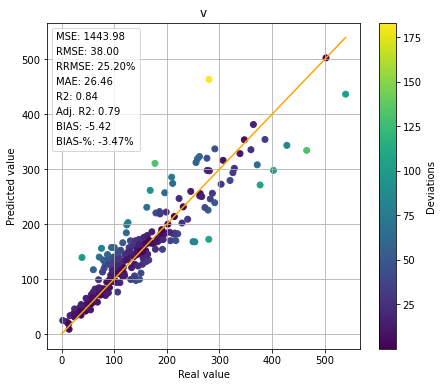

In [43]:
ens_int.plot_results()
plt.show()

Run test set predictions.

In [55]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,37.663593,24.776455,0.897448,0.590373,26.763708,0.849259
1,0,42.186283,27.751642,-2.104330,-1.384304,31.099106,0.810883
2,1,41.967667,27.607828,2.612102,1.718334,29.261814,0.812838
3,2,40.969700,26.951330,2.487811,1.636571,30.231760,0.821633
4,3,37.440872,24.629942,1.821014,1.197928,27.103006,0.851036
5,4,42.817543,28.166908,1.225528,0.806196,29.775957,0.805181
6,5,44.040543,28.971443,0.339224,0.223154,31.538509,0.793892
7,6,39.418530,25.930918,0.414753,0.272840,27.883177,0.834884
8,7,42.483612,27.947239,-0.410631,-0.270128,30.548061,0.808207
9,8,39.598988,26.049629,3.569808,2.348347,28.522034,0.833369


In [56]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

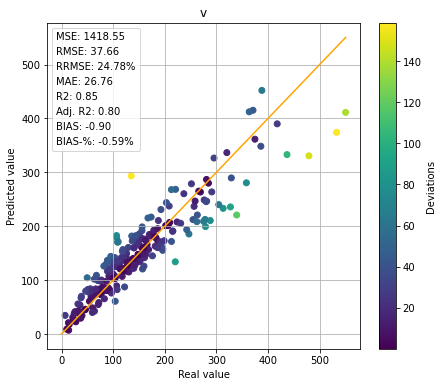

In [57]:
test_ens_interp.plot_results()
plt.show()

# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [36]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [37]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [38]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [39]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

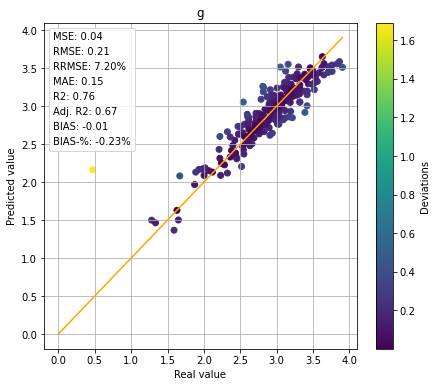

In [40]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

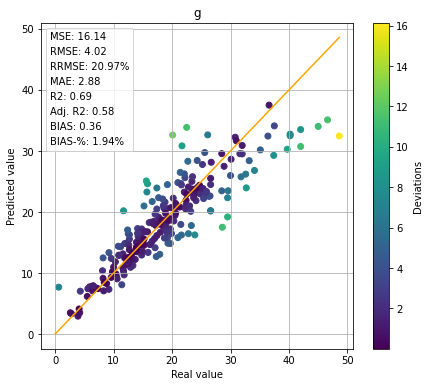

In [41]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=True)
plt.show()

Test results

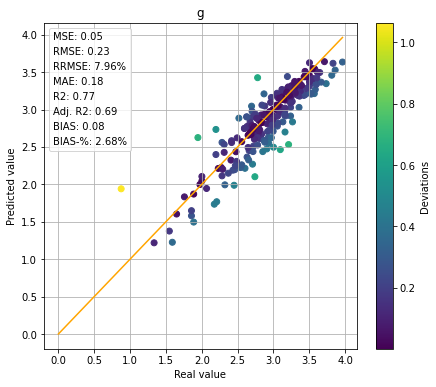

In [42]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

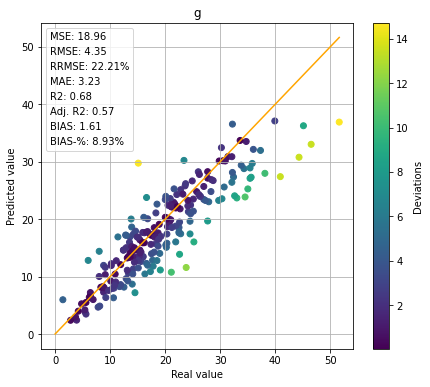

In [43]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys, log_y=True)
plt.show()